# Loading Libraries

In [22]:

import numpy as np
import pandas as pd
import six
from random import randint
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

import tensorflow as tf
import keras
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.losses import binary_crossentropy
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

from keras.preprocessing.image import load_img
from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects
from keras.applications.xception import Xception
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy

# Params and helpers

In [3]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Loading of training/testing ids and depths

In [5]:
#!unzip /kaggle/input/tgs-salt-identification-challenge/train.zip

In [6]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/tgs-salt-identification-challenge/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/tgs-salt-identification-challenge/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [7]:
train_df["images"] = [np.array(load_img("/kaggle/working/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("/kaggle/working/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [8]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [9]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 31)

In [9]:
x_train.shape

(3200, 128, 128, 1)

# Calculating IOU

In [10]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [12]:
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            ModelCheckpoint("./Xception_unet.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            LearningRateScheduler(schedule=self._cosine_anneal_schedule)
            #ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.2, patience=5, min_lr=0.00001, verbose=1)

        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

Useful Model Blocks

In [13]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

# Defining Unet Model

In [14]:
def UXception(input_shape=(None, None, 3)):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    # 10 -> 20
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.1)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    # 10 -> 20
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(0.1)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    # 20 -> 40
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    # 40 -> 80
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    
    # 80 -> 160
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(0.1/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model


# Defining the Normalized Gradient SGD Optimizer

This leads to much faster converagnce as compare to normal SGD.

In [15]:
# https://github.com/titu1994/keras-normalized-optimizers
# Computes the L-2 norm of the gradient.
def l2_norm(grad):
    norm = K.sqrt(K.sum(K.square(grad))) + K.epsilon()
    return norm

class OptimizerWrapper(optimizers.Optimizer):

    def __init__(self, optimizer):     
        
        self.optimizer = optimizers.get(optimizer)

        # patch the `get_gradients` call
        self._optimizer_get_gradients = self.optimizer.get_gradients

    def get_gradients(self, loss, params):      
        grads = self._optimizer_get_gradients(loss, params)
        return grads

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        # monkey patch `get_gradients`
        self.optimizer.get_gradients = self.get_gradients

        # get the updates
        self.optimizer.get_updates(loss, params)

        # undo monkey patch
        self.optimizer.get_gradients = self._optimizer_get_gradients

        return self.updates

    def set_weights(self, weights):       
        self.optimizer.set_weights(weights)

    def get_weights(self):        
        return self.optimizer.get_weights()

    def get_config(self):       
        # properties of NormalizedOptimizer
        config = {'optimizer_name': self.optimizer.__class__.__name__.lower()}

        # optimizer config
        optimizer_config = {'optimizer_config': self.optimizer.get_config()}
        return dict(list(optimizer_config.items()) + list(config.items()))

    @property
    def weights(self):
        return self.optimizer.weights

    @property
    def updates(self):
        return self.optimizer.updates

    @classmethod
    def from_config(cls, config):
        raise NotImplementedError

    @classmethod
    def set_normalization_function(cls, name, func):
        global _NORMS
        _NORMS[name] = func

    @classmethod
    def get_normalization_functions(cls):        
        global _NORMS
        return sorted(list(_NORMS.keys()))


class NormalizedOptimizer(OptimizerWrapper):

    def __init__(self, optimizer, normalization='l2'):       
        super(NormalizedOptimizer, self).__init__(optimizer)

        if normalization not in _NORMS:
            raise ValueError('`normalization` must be one of %s.\n' 
                             'Provided was "%s".' % (str(sorted(list(_NORMS.keys()))), normalization))

        self.normalization = normalization
        self.normalization_fn = _NORMS[normalization]
        self.lr = K.variable(1e-3, name='lr')

    def get_gradients(self, loss, params):       
        grads = super(NormalizedOptimizer, self).get_gradients(loss, params)
        grads = [grad / self.normalization_fn(grad) for grad in grads]
        return grads

    def get_config(self):        
        # properties of NormalizedOptimizer
        config = {'normalization': self.normalization}

        # optimizer config
        base_config = super(NormalizedOptimizer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):       
        optimizer_config = {'class_name': config['optimizer_name'],
                            'config': config['optimizer_config']}

        optimizer = optimizers.get(optimizer_config)
        normalization = config['normalization']

        return cls(optimizer, normalization=normalization)


_NORMS = {
    'l2': l2_norm,
}

# register this optimizer to the global custom objects when it is imported
get_custom_objects().update({'NormalizedOptimizer': NormalizedOptimizer})

In [16]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [23]:
# model

model = UXception(input_shape=(img_size_target,img_size_target,3))


In [24]:
sgd = SGD(0.01, momentum=0.9, nesterov=True)
sgd = NormalizedOptimizer(sgd, normalization='l2')

In [25]:
model.compile(loss=bce_dice_loss, optimizer=sgd, metrics=[my_iou_metric])

# Augmentation using fliplr

I only augment the images in training set.  I repeat the image in to get 3 channels which is required for using pretrained imagenet models.

In [26]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 128, 128, 1)
(800, 128, 128, 1)


In [27]:
x_train = np.repeat(x_train,3,axis=3)
x_valid = np.repeat(x_valid,3,axis=3)

In [28]:
epochs = 100
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
batch_size = 32
swa = SWA('./Xception_unet.h5',70)
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=snapshot.get_callbacks(),shuffle=True,verbose=2)

Train on 6400 samples, validate on 800 samples
Stochastic weight averaging selected for last 30 epochs.
Epoch 1/100
 - 84s - loss: 0.5433 - my_iou_metric: 0.5206 - val_loss: 1.3266 - val_my_iou_metric: 0.3804

Epoch 00001: val_my_iou_metric improved from -inf to 0.38037, saving model to ./Xception_unet.model
Epoch 2/100
 - 59s - loss: 0.3588 - my_iou_metric: 0.6849 - val_loss: 0.5997 - val_my_iou_metric: 0.6555

Epoch 00002: val_my_iou_metric improved from 0.38037 to 0.65550, saving model to ./Xception_unet.model
Epoch 3/100
 - 59s - loss: 0.3028 - my_iou_metric: 0.7303 - val_loss: 0.4059 - val_my_iou_metric: 0.7172

Epoch 00003: val_my_iou_metric improved from 0.65550 to 0.71725, saving model to ./Xception_unet.model
Epoch 4/100
 - 59s - loss: 0.2598 - my_iou_metric: 0.7529 - val_loss: 0.3782 - val_my_iou_metric: 0.7688

Epoch 00004: val_my_iou_metric improved from 0.71725 to 0.76875, saving model to ./Xception_unet.model
Epoch 5/100
 - 59s - loss: 0.2350 - my_iou_metric: 0.7692 - val

In [ ]:
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('model iou metric')
plt.ylabel('val_my_iou_metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [29]:
# Load best model
try:
    
    model.load_weights('./Xception_unet.h5')
    print('using swa weight model')
except:
    model.load_weights('./Xception_unet.model')

using swa weight model


# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [30]:
def predict_result(model,x_test,img_size_target,batch_size): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict([x_test],batch_size=batch_size).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict([x_test_reflect],batch_size=batch_size).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [31]:
preds_valid = predict_result(model,x_valid,img_size_target,batch_size)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([downsample(x) for x in y_valid])

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

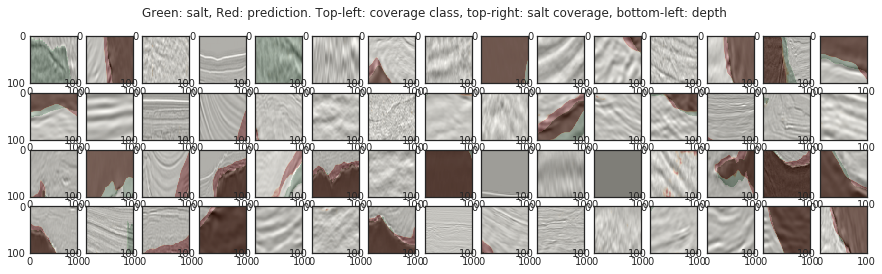

In [32]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = x_valid[i]
    mask = y_valid[i].squeeze()
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [33]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [34]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

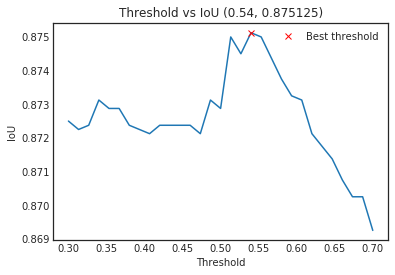

In [35]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [36]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metrics(preds_valid, y_valid_ori, threshold=0.5):
  """Calculates precision, recall, F1-score, and accuracy for binary classification.

  Args:
    preds_valid: Predicted probabilities.
    y_valid_ori: Original probability maps.
    threshold: Threshold for binarizing predictions.

  Returns:
    A tuple of precision, recall, F1-score, and accuracy.
  """

  y_valid_bin = np.where(y_valid_ori > threshold, 1, 0)
  y_valid_flat = y_valid_bin.flatten()
  preds_valid_bin_flat = (preds_valid > threshold).astype(np.uint8).flatten()

  precision = precision_score(y_valid_flat, preds_valid_bin_flat)
  recall = recall_score(y_valid_flat, preds_valid_bin_flat)
  f1 = f1_score(y_valid_flat, preds_valid_bin_flat)
  accuracy = accuracy_score(y_valid_flat, preds_valid_bin_flat)

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)
  print("Accuracy:", accuracy)

  return precision, recall, f1, accuracy

In [37]:
calculate_metrics(preds_valid, y_valid_ori)

Precision: 0.9659573823274761
Recall: 0.91136474782691
F1-score: 0.9378672866164162
Accuracy: 0.969985418096265


(0.9659573823274761, 0.91136474782691, 0.9378672866164162, 0.969985418096265)

# Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

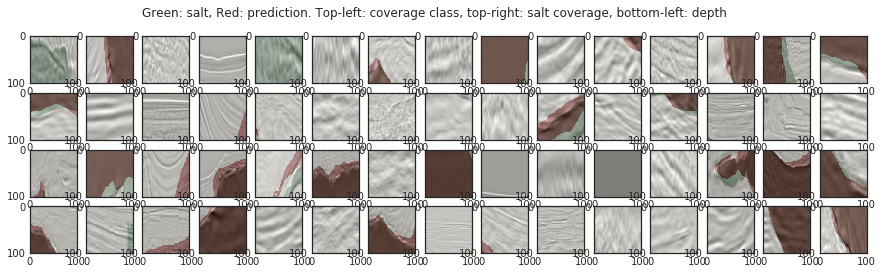

In [38]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = x_valid[i]
    mask = y_valid[i].squeeze()
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [39]:
model.save('Xception_unet.h5')

In [40]:
model.save('Xception_unet.model')

In [42]:
from IPython.display import FileLink
FileLink(r'Xception_unet.model')

/kaggle/working/Xception_unet.model